In [53]:
# Craig Phayer - 21340633
# Adam Collins - 21332967

# The code executes to the end without an error.

# Sources Cited:
# 

In [1]:
# Imports
import kagglehub
from pathlib import Path
from PIL import Image
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
from tensorflow.python.eager.profiler_client import monitor

C:\Users\craig\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset Link: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
# All images are 224 x 224 x 3 in jpg format and are cropped to ensure only the image of a single card is present, and the card occupies over 50% of the pixels in the image.

# Fetches the dataset from Kaggle and downloads it onto the local machine.
dataset_path = Path(kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification"))

# Prints the location of the dataset, confirming the correct download path.
print("Path to dataset files:", dataset_path)

# Prints all items within the dataset path, providing an overview of the datasets structure.
print("Contents of dataset_path:", list(dataset_path.iterdir()))

Path to dataset files: C:\Users\craig\.cache\kagglehub\datasets\gpiosenka\cards-image-datasetclassification\versions\2
Contents of dataset_path: [WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/14card types-14-(200 X 200)-94.61.h5'), WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/53cards-53-(200 X 200)-100.00.h5'), WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/cards.csv'), WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'), WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'), WindowsPath('C:/Users/craig/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid')]


Total images loaded from 'train' folder: 7624
Sample labels: ['ace of clubs', 'ace of clubs', 'ace of clubs', 'ace of clubs', 'ace of clubs']
Classes: ['test', 'train', 'valid']


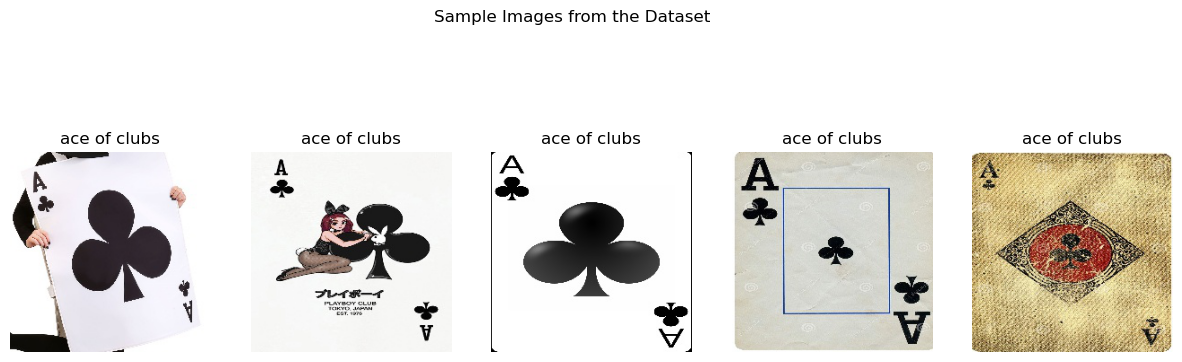

In [3]:
# Organising and checking the dataset.
# Prints sample images to confirm loading and labels.

# Empty lists used to store the file paths of images and their labels.
image_paths = []
labels = []

# Only looping through the 'train' directory to gather images and labels.
# We are using the train directory to both train and test our CNN.
train_path = dataset_path / 'train'
for class_folder in train_path.iterdir():
    if class_folder.is_dir():
        # Assigns the folder name as the label.
        label = class_folder.name
        for img_file in class_folder.glob("*.jpg"):
            image_paths.append(img_file)
            labels.append(label)
            

# Prints total number of images loaded & displays first 5 labels.
print(f"Total images loaded from 'train' folder: {len(image_paths)}")
print("Sample labels:", labels[:5])

# Collects the names of all folders within the dataset path that represent the different classes, and prints the list of class names.
class_names = [folder.name for folder in dataset_path.iterdir() if folder.is_dir()]
print("Classes:", class_names)

# Visualises a sample of the images.
def display_sample_images(num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Sample Images from the Dataset")

    for i in range(num_samples):
        image_path = image_paths[i]
        label = labels[i]

        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis("off")

    plt.show()

display_sample_images(5)

Splitting the dataset into training and testing.

In [4]:
from sklearn.model_selection import train_test_split

# Using test_train_split from sklearn to split dataset into training and testing.
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

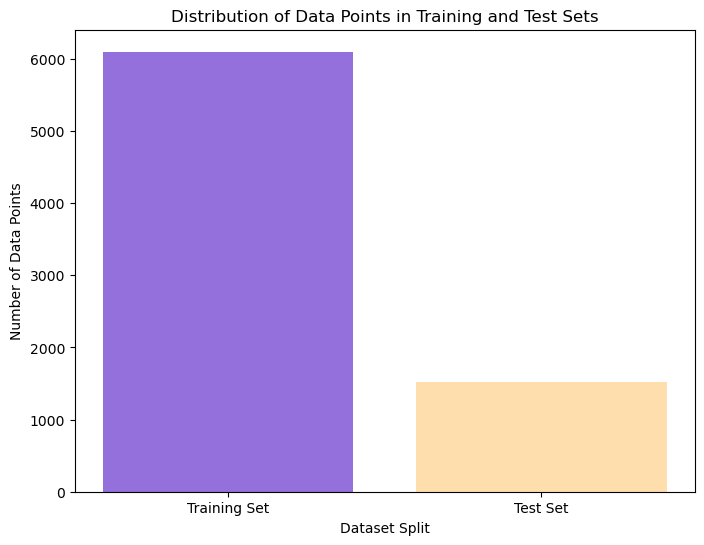

In [5]:
# Visualising our training and testing sets.

# Number of data points.
training_data_count = len(y_train)
testing_data_count = len(y_test)

# Define categories and their counts.
data_categories = ['Training Set', 'Test Set']
data_counts = [training_data_count, testing_data_count]

# Print the barchart.
plt.figure(figsize=(8, 6))
plt.bar(data_categories, data_counts, color=['mediumpurple', 'navajowhite'])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points in Training and Test Sets')
plt.show()

### InceptionV3

In [6]:
def inceptionV3_model(optimizer='Adam', learning_rate=0.0005):

    # Model preparation
    base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    # Init freeze all layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True


    x = layers.Flatten()(base_model.output)
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(53, activation="softmax")(x)

    if optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type. Choose 'RMSprop', 'Adam', or 'SGD'.")

    model = Model(base_model.input, output)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

inceptionV3_model().summary()    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### K-Fold cross validation

In [7]:
def k_fold(build_fn, n_splits=5, batch_size=32, epochs=20, verbose=1):
    # Convert to DataFrame for k-folds
    df = pd.DataFrame({"filename": image_paths, "class": labels})
    
    # Augment the images in our dataset
    # - rescale the images into normalized values [0,1]
    # - image rotation so during training the model can better generalize
    # - shift images vertically and horizontally by 20% so the model becomes better at dealing with invariants in images
    # - zoom in/out for better recognition of objects at different scales
    data_gen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=50,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    histories = []
    
    for train_idx, val_idx in kfold.split(df["filename"], df["class"]):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        train_df['filename'] = train_df['filename'].astype(str)
        val_df['filename'] = val_df['filename'].astype(str)
    
        train_generator = data_gen.flow_from_dataframe(
            train_df,
            x_col="filename",
            y_col="class",
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=batch_size
        )
    
        val_generator = data_gen.flow_from_dataframe(
            val_df,
            x_col="filename",
            y_col="class",
            target_size=(224, 224),
            class_mode="categorical",
            batch_size=batch_size
        )

        model = build_fn()
        # Monitor val_loss, if it stops improving or increases the scheduler reduces the learning rate by the set factor
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3)
        #patience = the no. of epochs the scheduler will wait before triggering

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        class_weights = dict(enumerate(class_weights))
    
        print(f"Training on fold {fold_no}...")
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=[lr_scheduler, early_stopping],
            class_weight=class_weights,
            verbose=verbose
        )
        fold_no += 1
        
        histories.append(history)
    return histories

iV3 = k_fold(inceptionV3_model)

Found 6099 validated image filenames belonging to 53 classes.


C:\Users\craig\AppData\Local\Temp\ipykernel_17176\3378383937.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['filename'] = train_df['filename'].astype(str)
C:\Users\craig\AppData\Local\Temp\ipykernel_17176\3378383937.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['filename'] = val_df['filename'].astype(str)


Found 1525 validated image filenames belonging to 53 classes.
Training on fold 1...
Epoch 1/20
191/191 [==============================] - 50s 236ms/step - loss: 4.3829 - acc: 0.1154 - val_loss: 3.4213 - val_acc: 0.2498 - lr: 5.0000e-04
Epoch 2/20
191/191 [==============================] - 46s 240ms/step - loss: 3.4324 - acc: 0.2082 - val_loss: 2.6355 - val_acc: 0.2984 - lr: 5.0000e-04
Epoch 3/20
191/191 [==============================] - 46s 240ms/step - loss: 3.0450 - acc: 0.2571 - val_loss: 2.5738 - val_acc: 0.3318 - lr: 5.0000e-04
Epoch 4/20
191/191 [==============================] - 46s 241ms/step - loss: 2.8245 - acc: 0.2882 - val_loss: 2.4247 - val_acc: 0.3698 - lr: 5.0000e-04
Epoch 5/20
191/191 [==============================] - 46s 241ms/step - loss: 2.5175 - acc: 0.3361 - val_loss: 2.2213 - val_acc: 0.3830 - lr: 5.0000e-04
Epoch 6/20
191/191 [==============================] - 46s 239ms/step - loss: 2.3138 - acc: 0.3773 - val_loss: 2.2130 - val_acc: 0.4059 - lr: 5.0000e-04
Epoc

KeyboardInterrupt: 